# 09. PyTorch Model Deployment

What is model deployment?
Machine learning model deployment is the act of making your machine learning model(s) available to someone or something

## Resources:
* Book version of notebook: https://www.learnpytorch.io/09_pytorch model deployment/
* Slides: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/09_pytorchmodel deployment.pdf

## 0. Get Setup

In [21]:
import matplotlib.pyplot as plt
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from param import output

from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [26]:
data_20_percent_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
    destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [28]:
# Setup training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline
### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible.

To try and achieve these goals, we're going to build two model experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper

## 3. Creating an EffNetB2 feature extractor
Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch -
https://docs.pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet

In [41]:
import torchvision

# Create an EffNetB2
effnetB2 = torchvision.models.efficientnet_b2(weights="DEFAULT").to(device)

for param in effnetB2.parameters():
    param.requires_grad = False

effnetB2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [42]:
summary(effnetB2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [43]:
effnetB2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [45]:
set_seeds()
effnetB2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=1000, bias=True),
)

### 3.1 Creating a function to make an EffNetB2 feature

In [55]:
def create_effnetb2_model(num_classes:int=3,# default output classes = 3 (pizza, steak, sushi)
                          seed:int=42):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    transforms = weights.transforms()

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=1000, bias=True),
    )

    return model, transforms

In [56]:
effnetB2_model, effnetB2_transforms = create_effnetb2_model()

In [58]:
summary(effnetB2_model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [63]:
train_dataloader_effnetB2, test_dataloader_effnetB2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=effnetB2_transforms,
                                                                               test_transform=effnetB2_transforms,
                                                                               batch_size=32)

In [67]:
len(train_dataloader_effnetB2), len(test_dataloader_effnetB2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

#3.3 Training EffNetB2 feature extractor

In [72]:
from going_modular import data_setup, engine

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(effnetB2_model.parameters(), lr=0.001)

# Training function (engine.py)
set_seeds()
effnetB2_results = engine.train(
    effnetB2_model,
    train_dataloader_effnetB2,
    test_dataloader_effnetB2,
    optimizer,
    loss_fn,
    10,
    device
)

Epoch: 10 | train_loss: 0.4964 | train_acc: 0.9313 | test_loss: 0.5988 | test_acc: 0.9597


### 3.4 Inspecting EffNetB2 loss curves

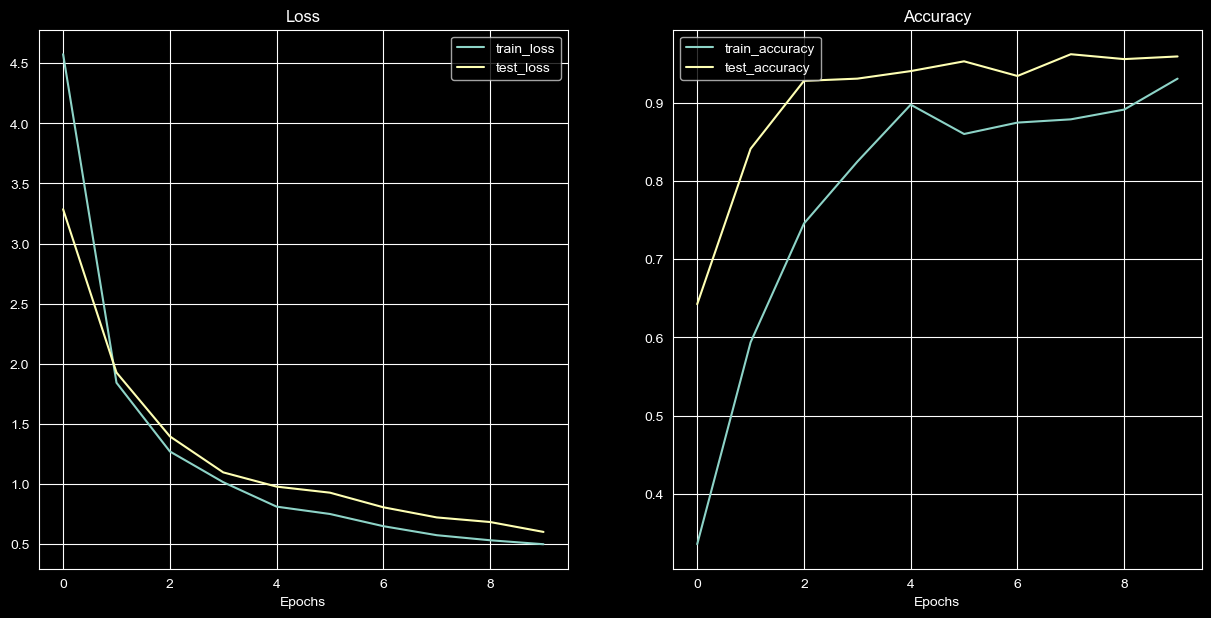

In [75]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetB2_results)

# \# Progress updates

In [73]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print

update_progress(video_index=284, done=True)

Updated progress report. 
Video: 284. Training Our EffNetB2 Feature Extractor and Inspecting the Loss Curves 
Duration: 9m 
Status: Done 
Date: 09 Feb 2026 04:56 PM 
Section progress: 
Section : 11.PyTorch Model Deployment
Status  : 44 videos remaining, 6h 10m to finish the section
Progress:  23%|██████▌                       13/57


In [74]:
progress_report_print()

      ___         ___           ___           ___           ___           ___           ___           ___     
     /  /\       /  /\         /  /\         /  /\         /  /\         /  /\         /  /\         /  /\    
    /  /::\     /  /::\       /  /::\       /  /:/_       /  /::\       /  /:/_       /  /:/_       /  /:/_   
   /  /:/\:\   /  /:/\:\     /  /:/\:\     /  /:/ /\     /  /:/\:\     /  /:/ /\     /  /:/ /\     /  /:/ /\  
  /  /:/~/:/  /  /:/~/:/    /  /:/  \:\   /  /:/_/::\   /  /:/~/:/    /  /:/ /:/_   /  /:/ /::\   /  /:/ /::\ 
 /__/:/ /:/  /__/:/ /:/___ /__/:/ \__\:\ /__/:/__\/\:\ /__/:/ /:/___ /__/:/ /:/ /\ /__/:/ /:/\:\ /__/:/ /:/\:\
 \  \:\/:/   \  \:\/:::::/ \  \:\ /  /:/ \  \:\ /~~/:/ \  \:\/:::::/ \  \:\/:/ /:/ \  \:\/:/~/:/ \  \:\/:/~/:/
  \  \::/     \  \::/~~~~   \  \:\  /:/   \  \:\  /:/   \  \::/~~~~   \  \::/ /:/   \  \::/ /:/   \  \::/ /:/ 
   \  \:\      \  \:\        \  \:\/:/     \  \:\/:/     \  \:\        \  \:\/:/     \__\/ /:/     \__\/ /:/  
 

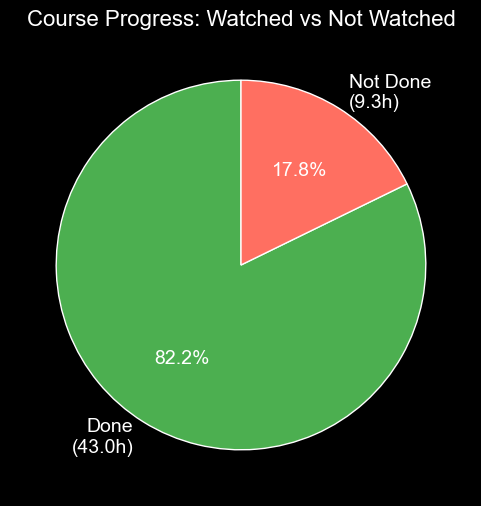

In [77]:
progress_pie_chart()